# Random Forest Classifier
with PCA dimension reduction and Gridsearch

In [1]:
import numpy as np # numbers and algebra in python
import pandas as pd # tables and processing tabular data


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

In [3]:
index_names = ['unit_number', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i+1) for i in range(0,21)]
col_names = index_names + setting_names + sensor_names

In [4]:
dirPath = './archive/CMaps/'

train = pd.read_csv(dirPath + 'train_FD001.txt',sep='\s+',names=col_names)
test = pd.read_csv(dirPath + 'test_FD001.txt',sep='\s+',names=col_names)
y_test = pd.read_csv(dirPath + 'RUL_FD001.txt',sep='\s+',header=None)


In [5]:
train[index_names].groupby('unit_number').max().describe()

,time_cycles
count,100.000000
mean,206.310000
std,46.342749
min,128.000000
25%,177.000000
50%,199.000000
75%,229.250000
max,362.000000


In [6]:
def gate_the_RUL(train,cap=150):
    # Rectifier
    train['RUL'] = np.minimum(train['RUL'],cap)
    return train

def add_remaining_useful_life(df):
    # Get the total number of cycles for each unit
    grouped_by_unit = df.groupby(by="unit_number")
    max_cycle = grouped_by_unit["time_cycles"].max()
    
    # Merge the max cycle back into the original frame
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='unit_number', right_index=True)
    
    # Calculate remaining useful life for each row
    remaining_useful_life = result_frame["max_cycle"] - result_frame["time_cycles"]
    result_frame["RUL"] = remaining_useful_life
    
    # drop max_cycle as it's no longer needed
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame

As we discussed previously, we can gate the RUL during training if we "don't care about it above a threshold".
Consider histograms later in this script to understand why

In [7]:
train = add_remaining_useful_life(train)
train = gate_the_RUL(train,cap=150)

train[index_names+['RUL']] # last thing in cell prints out

,unit_number,time_cycles,RUL
0,1,1,150
1,1,2,150
2,1,3,150
3,1,4,150
4,1,5,150
...,...,...,...
20626,100,196,4
20627,100,197,3
20628,100,198,2
20629,100,199,1


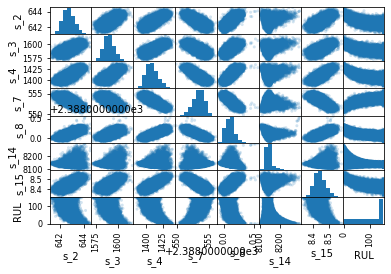

In [8]:
# Here are a small selection of useful looking signals, along with our taregt (RUL)
good_sensors = ['s_2', 's_3', 's_4', 's_7', 's_8','s_14','s_15']
pd.plotting.scatter_matrix(train.loc[:,good_sensors + ["RUL"]], alpha=0.2)
plt.show()

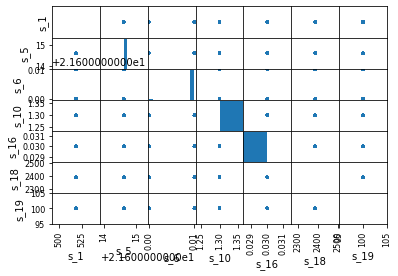

In [9]:
# these seem not worth keeping
import warnings
warnings.filterwarnings("ignore")
# drop_sensors = ['s_1','s_5','s_16','s_18','s_19'] # as per last week..
drop_sensors = ['s_1','s_5','s_6','s_10','s_16','s_18','s_19'] # new bad signals noted. 

pd.plotting.scatter_matrix(train.loc[:,drop_sensors])
plt.show()

In [10]:
drop_labels = setting_names+drop_sensors


In [11]:
X_train = train.drop(drop_labels, axis=1)
y_train = X_train.pop('RUL')

In [12]:
X_test = test.groupby('unit_number').last().reset_index().drop(drop_labels, axis=1)

In [13]:
X_test

,unit_number,time_cycles,s_2,s_3,s_4,s_7,s_8,s_9,s_11,s_12,s_13,s_14,s_15,s_17,s_20,s_21
0,1,31,642.58,1581.22,1398.91,554.42,2388.08,9056.40,47.23,521.79,2388.06,8130.11,8.4024,393,38.81,23.3552
1,2,49,642.55,1586.59,1410.83,553.52,2388.10,9044.77,47.67,521.74,2388.09,8126.90,8.4505,391,38.81,23.2618
2,3,126,642.88,1589.75,1418.89,552.59,2388.16,9049.26,47.88,520.83,2388.14,8131.46,8.4119,395,38.93,23.2740
3,4,106,642.78,1594.53,1406.88,552.64,2388.13,9051.30,47.65,521.88,2388.11,8133.64,8.4634,395,38.58,23.2581
4,5,98,642.27,1589.94,1419.36,553.29,2388.10,9053.99,47.46,521.00,2388.15,8125.74,8.4362,394,38.75,23.4117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,97,642.30,1590.88,1397.94,553.99,2388.03,9062.41,47.14,522.30,2388.01,8148.24,8.4110,391,38.96,23.4606
96,97,134,642.59,1582.96,1410.92,554.05,2388.06,9076.36,47.38,521.58,2388.06,8155.48,8.4500,395,38.61,23.2953
97,98,121,642.68,1599.51,1415.47,553.44,2388.13,9062.34,47.66,521.53,2388.09,8146.39,8.4235,394,38.76,23.3608
98,99,97,642.00,1585.03,1397.98,554.75,2388.01,9067.16,47.26,521.82,2388.02,8150.38,8.4003,391,38.95,23.3595


If we wished to investigate whether moving averages would help on the training data, remove """ in the cell below.


In [14]:
f = lambda x: x.rolling(5,min_periods=0).mean() #.shift()
X_train = X_train.groupby('unit_number').apply(f)
X_train

,unit_number,time_cycles,s_2,s_3,s_4,s_7,s_8,s_9,s_11,s_12,s_13,s_14,s_15,s_17,s_20,s_21
0,1.0,1.0,641.820000,1589.700000,1400.600000,554.360000,2388.0600,9046.190000,47.470,521.660,2388.020,8138.620000,8.419500,392.000000,39.060000,23.419000
1,1.0,1.5,641.985000,1590.760000,1401.870000,554.055000,2388.0500,9045.130000,47.480,521.970,2388.045,8135.055000,8.425650,392.000000,39.030000,23.421300
2,1.0,2.0,642.106667,1589.836667,1402.646667,554.123333,2388.0600,9047.733333,47.410,522.120,2388.040,8134.446667,8.423033,391.333333,39.003333,23.395600
3,1.0,2.5,642.167500,1588.075000,1402.452500,554.205000,2388.0725,9048.170000,47.340,522.305,2388.050,8134.292500,8.409325,391.500000,38.972500,23.390175
4,1.0,3.0,642.208000,1587.030000,1403.206000,554.164000,2388.0700,9049.566000,47.328,522.282,2388.048,8134.194000,8.413340,391.800000,38.958000,23.393020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100.0,194.0,643.448000,1599.270000,1427.270000,551.604000,2388.2220,9066.416000,48.156,519.890,2388.232,8141.130000,8.520120,395.800000,38.408000,23.079640
20627,100.0,195.0,643.450000,1599.924000,1430.090000,551.548000,2388.2340,9067.348000,48.128,519.708,2388.234,8139.738000,8.525060,395.400000,38.356000,23.096120
20628,100.0,196.0,643.516000,1600.454000,1429.940000,551.328000,2388.2240,9067.014000,48.108,519.688,2388.244,8139.544000,8.529500,395.600000,38.350000,23.078180
20629,100.0,197.0,643.418000,1602.048000,1429.764000,551.066000,2388.2280,9067.988000,48.162,519.712,2388.246,8139.468000,8.532980,395.800000,38.332000,23.064500


In [15]:
# zero-centered normalise (standardise or zscore)
# use pipeline instead
# X_train = (X_train - np.mean(X_train)) / np.std(X_train)
# X_test = (X_test - np.mean(X_test)) / np.std(X_test)

In [16]:
from sklearn.decomposition import PCA
reduce_dim = 8

pca = PCA(n_components=reduce_dim)
pca.fit(X_train)

print(pca.explained_variance_ratio_)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

feature_names = ['pca_{}'.format(i+1) for i in range(0,reduce_dim)]
feature_names

[7.66505777e-01 1.34801608e-01 9.03844419e-02 7.33820176e-03
 5.09739121e-04 4.05044453e-04 3.78335836e-05 9.57543781e-06]


['pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']

In [17]:
img_rows, img_cols = 1, reduce_dim
input_shape = (img_rows, img_cols, 1)

In [18]:
X_train.shape

(20631, 8)

In [19]:
f = lambda y: y<=30

y_train = y_train.apply(f)
y_test = y_test.apply(f)
y_test = np.squeeze(y_test)


In [20]:
np.mean(y_train)

0.15025931850128446

In [21]:
np.mean(y_test)

0.25

In [22]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


classModel = make_pipeline(StandardScaler(),RandomForestClassifier(max_depth=5, random_state=123))
classModel.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=5, random_state=123))])

In [23]:
model_pred = classModel.predict(X_test) # inferencing

accu = np.mean( y_test == model_pred)
accu

0.9

In the next section we define a custom metric, we manually split and shuffle data

array([[75,  0],
       [10, 15]], dtype=int64)

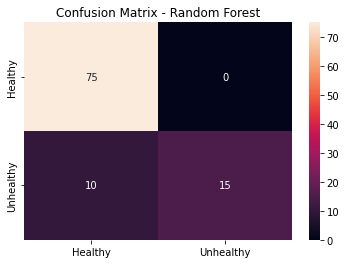

In [24]:
from sklearn.metrics import confusion_matrix, cohen_kappa_score

cm = confusion_matrix(np.squeeze(y_test), model_pred)
cmplot = sns.heatmap(cm,annot=True,xticklabels=["Healthy","Unhealthy"],yticklabels=["Healthy","Unhealthy"] )
cmplot.set_title("Confusion Matrix - Random Forest" )

cm

In [25]:
cohen_kappa_score(y_test, model_pred)

0.6923076923076923

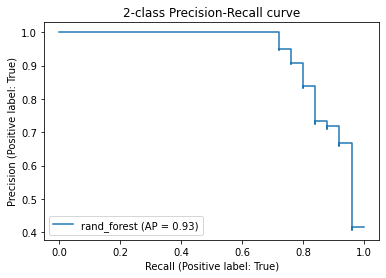

In [26]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(
    classModel, X_test, y_test, name="rand_forest"
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

In [29]:
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score,roc_auc_score
# we could have a nice function for summarising a range of common classification stats
def binary_classification_performance(y_test, y_pred):
    tp, fp, fn, tn = confusion_matrix(y_test, y_pred).ravel()
    accuracy = round(accuracy_score(y_pred = y_pred, y_true = y_test),2)
    precision = round(precision_score(y_pred = y_pred, y_true = y_test),2)
    recall = round(recall_score(y_pred = y_pred, y_true = y_test),2)
    f1_score = round(2*precision*recall/(precision + recall),2)
    specificity = round(tn/(tn+fp),2)
    npv = round(tn/(tn+fn),2)
    auc_roc = round(roc_auc_score(y_score = y_pred, y_true = y_test),2)


    result = pd.DataFrame({'Accuracy' : [accuracy],
                         'Precision (or PPV)' : [precision],
                         'Recall (senitivity or TPR)' : [recall],
                         'f1 score' : [f1_score],
                         'AUC_ROC' : [auc_roc],
                         'Specificty (or TNR)': [specificity],
                         'NPV' : [npv],
                         'True Positive' : [tp],
                         'True Negative' : [tn],
                         'False Positive':[fp],
                         'False Negative':[fn]})
    return result


binary_classification_performance(y_test, model_pred)

,Accuracy,Precision (or PPV),Recall (senitivity or TPR),f1 score,AUC_ROC,Specificty (or TNR),NPV,True Positive,True Negative,False Positive,False Negative
0,0.9,1.0,0.6,0.75,0.8,1.0,0.6,75,15,0,10


In [31]:
# outer loop auto-ML
# set random state for repeatability
from sklearn.model_selection import GridSearchCV
## Define Grid 
grid = { 
    'n_estimators': [25,50,100],
    'max_depth' : [3,4,5],
    'random_state' : [18]
}

## Grid Search function
CV_rforest = GridSearchCV(estimator=RandomForestClassifier(max_depth=5, random_state=123), param_grid=grid, cv= 5)
CV_rforest.fit(X_train, y_train)
## show end time


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(max_depth=5, random_state=123),
             param_grid={'max_depth': [3, 4, 5], 'n_estimators': [25, 50, 100],
                         'random_state': [18]})

In [32]:
model_gs = CV_rforest.best_estimator_
model_pred = model_gs.predict(X_test)


In [33]:
accu = np.mean( y_test == model_pred)
accu

0.93

array([[75,  0],
       [ 7, 18]], dtype=int64)

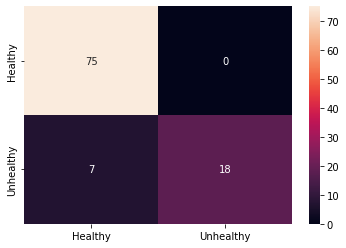

In [34]:
cm = confusion_matrix(np.squeeze(y_test), model_pred)
sns.heatmap(cm,annot=True,xticklabels=["Healthy","Unhealthy"],yticklabels=["Healthy","Unhealthy"] )
cm

In [35]:
cohen_kappa_score(y_test, model_pred)

0.7941176470588236

In [36]:
binary_classification_performance(y_test, model_pred)

,Accuracy,Precision (or PPV),Recall (senitivity or TPR),f1 score,AUC_ROC,Specificty (or TNR),NPV,True Positive,True Negative,False Positive,False Negative
0,0.93,1.0,0.72,0.84,0.86,1.0,0.72,75,18,0,7


Let's now plot the first tree in our ensemble. Remember there are many weak learners (trees) within the RandomForest model. We can access them by index 0,1,2..
Here, I've commented the long printout, leaving just an image of the start of it.

In [37]:
from sklearn import tree
# print(tree.export_text(model_gs.estimators_[0]))

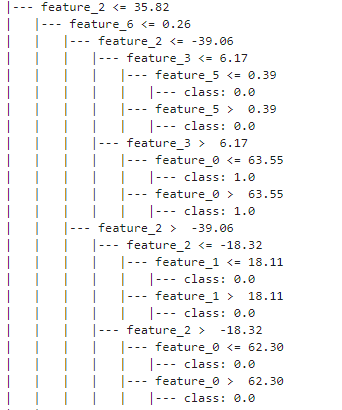
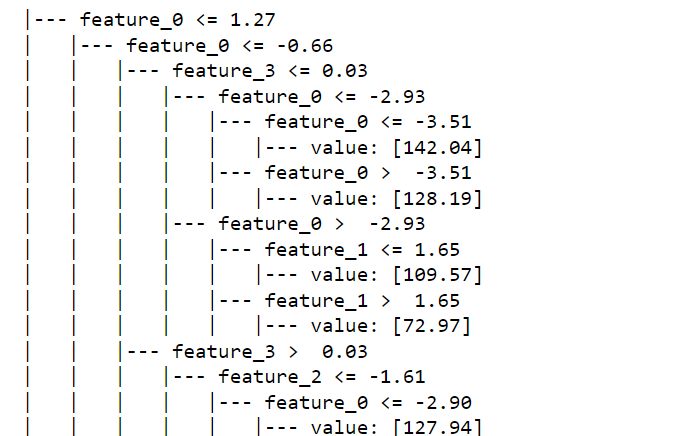

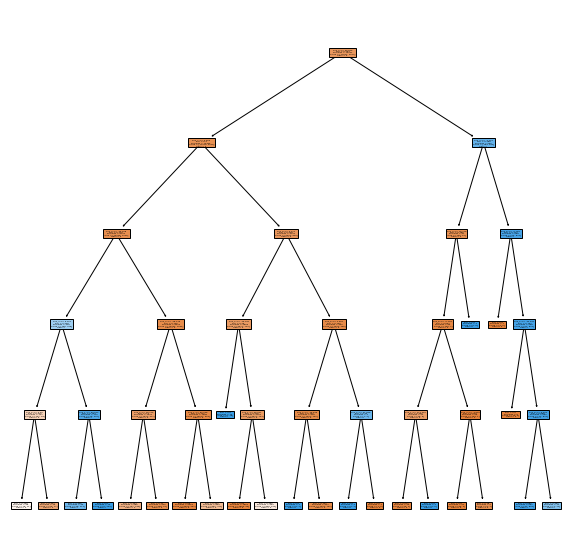

In [38]:
fig, ax = plt.subplots(figsize=(10,10))
tree.plot_tree(model_gs.estimators_[0], feature_names = feature_names, class_names = str(y_train), filled=True)
plt.show()

How many trees are in our total ensemble?
What are the model's (estimator's) parameters, that we could vary/tune?

In [39]:
len(model_gs.estimators_)

25

In [40]:
print(model_gs.estimator_params)

('criterion', 'max_depth', 'min_samples_split', 'min_samples_leaf', 'min_weight_fraction_leaf', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'random_state', 'ccp_alpha')


Here, we use evolutionary algorithms to deduce our most useful inputs.
Which should we keep, which should we throw away?

In [41]:
from genetic_selection import GeneticSelectionCV


selector = GeneticSelectionCV(
        estimator=RandomForestClassifier(max_depth=5, random_state=123),
        cv=5,
        verbose=1,
        scoring="accuracy",
        max_features=5,
        n_population=50,
        crossover_proba=0.5,
        mutation_proba=0.2,
        n_generations=40,
        crossover_independent_proba=0.5,
        mutation_independent_proba=0.05,
        tournament_size=3,
        n_gen_no_change=10,
        caching=True,
        n_jobs=-1,
    )
selector = selector.fit(X_train, y_train)

Selecting features with genetic algorithm.
gen	nevals	avg                            	std                            	min                            	max                            
0  	50    	[ 0.877931  3.56      0.035546]	[ 0.074696  1.283121  0.073286]	[ 0.610653  1.        0.000015]	[ 0.95182   5.        0.294615]
1  	26    	[-799.151359    4.2       800.014453]	[ 2713.182244     1.183216  2712.927731]	[-10000.            1.            0.000015]	[     0.952353      7.        10000.      ]
2  	36    	[-799.134276    4.52      800.008538]	[ 2713.187281     0.854166  2712.929476]	[-10000.            2.            0.003895]	[     0.952353      6.        10000.      ]
3  	27    	[-599.107309    4.38      600.006067]	[ 2375.093952     0.935735  2374.866885]	[-10000.            2.            0.004227]	[     0.952353      6.        10000.      ]
4  	27    	[-599.105407    4.9       600.005436]	[ 2375.094432     0.5       2374.867044]	[-10000.            3.            0.004227]	[     0.952

In [42]:
print(selector.support_)

[ True  True  True  True False  True False False]


In [44]:
ga_model = selector.estimator_

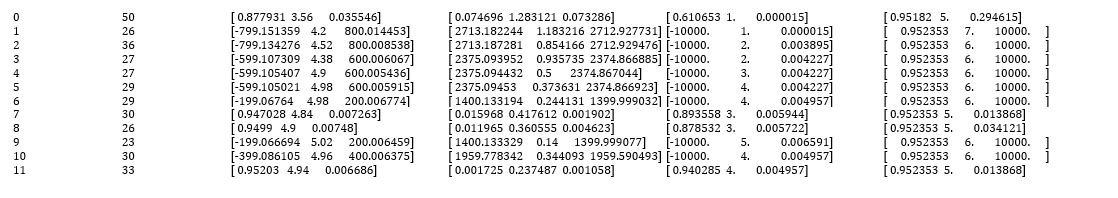

In [46]:
model_pred = ga_model.predict(X_test[:,selector.support_])
accu = np.mean( y_test == model_pred)
accu

0.92

array([[73,  2],
       [ 6, 19]], dtype=int64)

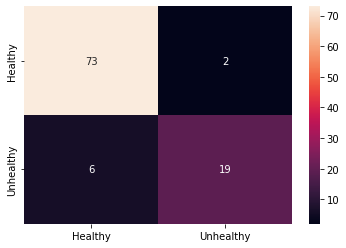

In [47]:
cm = confusion_matrix(np.squeeze(y_test), model_pred)
sns.heatmap(cm,annot=True,xticklabels=["Healthy","Unhealthy"],yticklabels=["Healthy","Unhealthy"] )
cm

In [48]:
binary_classification_performance(y_test, model_pred)

,Accuracy,Precision (or PPV),Recall (senitivity or TPR),f1 score,AUC_ROC,Specificty (or TNR),NPV,True Positive,True Negative,False Positive,False Negative
0,0.92,0.9,0.76,0.82,0.87,0.9,0.76,73,19,2,6
